In [1]:
#Importing packages

import xarray as xr
xr.set_options(display_style='html')
import intake
import cftime
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np
%matplotlib inline

In [2]:
#Reading files from bucket

import s3fs
s3 = s3fs.S3FileSystem(key="K1CQ7M1DMTLUFK182APD", 
                       secret="3JuZAQm5I03jtpijCpHOdkAsJDNLNfZxBpM15Pi0", 
                       client_kwargs=dict(endpoint_url="https://rgw.met.no"))
s3.ls('escience2022');

In [3]:
def computeWeightedMean(ds):
    # Compute weights based on the xarray you pass
    weights = np.cos(np.deg2rad(ds.lat))
    weights.name = "weights"
    # Compute weighted mean
    air_weighted = ds.weighted(weights)
    weighted_mean = air_weighted.mean(("lon", "lat"))
    return weighted_mean

In [4]:
def multi_plot(data,yr,cs):
    proj_plot = ccrs.Robinson(central_longitude=0, globe=None)

    p = data.sel(time = data.time.dt.year.isin([yr])).squeeze().plot(x='lon', y='lat',
                                                                     transform=ccrs.PlateCarree(),
                                                                     #aspect=dso4_3.dims["lon"] / dso4_3.dims["lat"],  # for a sensible figsize
                                                                     subplot_kws={"projection": proj_plot},
                                                                     col='time', col_wrap=4, robust=True, cmap=cs)
    # We have to set the map's options on all four axes
    for ax,i in zip(p.axes.flat,  data.time.sel(time = data.time.dt.year.isin([yr])).values):
        ax.coastlines()
        ax.set_title(i.strftime("%B %Y"), fontsize=18)

In [5]:
def calc_monthly_anomaly(ds,end_prior_eruption):
    start = ds.time[0].values
    end_prior_eruption = cftime.DatetimeNoLeap(end_prior_eruption,1,15)
    ds_post_eruption = ds
    ds_climatology = ds.sel(time=slice(start,end_prior_eruption)).groupby('time.month').mean('time', keep_attrs=True)
    ds_anomaly = ds_post_eruption.groupby('time.month') - ds_climatology
    ds_anomaly.attrs = ds_climatology.attrs
    return ds_anomaly

In [6]:
#Opening files

#Present day, Pinatubo 
#From experiment 14
#Columb O3
o3_cb_14 = 's3://escience2022/Zhihong/NFHISTnorpddmsbc_tropstratchem_f09_mg17_20220105_test14/cb_O3.NFHISTnorpddmsbc_tropstratchem_f09_mg17_20220105_test14.cam.h0.197001-201412.nc'
#Temperature
t_14 = 's3://escience2022/Zhihong/NFHISTnorpddmsbc_tropstratchem_f09_mg17_20220105_test14/T.NFHISTnorpddmsbc_tropstratchem_f09_mg17_20220105_test14.cam.h0.197001-201412.nc'
#Columb Sulfate
so4_cb_14 = 's3://escience2022/Zhihong/NFHISTnorpddmsbc_tropstratchem_f09_mg17_20220105_test14/cb_SULFATE.NFHISTnorpddmsbc_tropstratchem_f09_mg17_20220105_test14.cam.h0.197001-201412.nc'
#AOD sulfate 
aod_14 = 's3://escience2022/Zhihong/NFHISTnorpddmsbc_tropstratchem_f09_mg17_20220105_test14/D550_SO4.NFHISTnorpddmsbc_tropstratchem_f09_mg17_20220105_test14.cam.h0.197001-201412.nc'
#Ozone layers
o3_14 = 's3://escience2022/Zhihong/NFHISTnorpddmsbc_tropstratchem_f09_mg17_20220105_test14/O3.NFHISTnorpddmsbc_tropstratchem_f09_mg17_20220105_test14.cam.h0.197001-201412.nc'
#Sulfate in layers
so4_14 = 's3://escience2022/Zhihong/NFHISTnorpddmsbc_tropstratchem_f09_mg17_20220105_test14/mmr_SULFATE.NFHISTnorpddmsbc_tropstratchem_f09_mg17_20220105_test14.cam.h0.197001-201412.nc'
#SO2
so2_14 = 's3://escience2022/Zhihong/NFHISTnorpddmsbc_tropstratchem_f09_mg17_20220105_test14/SO2.NFHISTnorpddmsbc_tropstratchem_f09_mg17_20220105_test14.cam.h0.197001-201412.nc'



#From experiment 16
#Columb O3
o3_cb_16 = 's3://escience2022/Zhihong/NFHISTnorpddmsbc_tropstratchem_f09_mg17_20220105_test16/cb_O3.NFHISTnorpddmsbc_tropstratchem_f09_mg17_20220105_test16.cam.h0.197001-201412.nc'
o3_16 = 's3://escience2022/Zhihong/NFHISTnorpddmsbc_tropstratchem_f09_mg17_20220105_test16/O3.NFHISTnorpddmsbc_tropstratchem_f09_mg17_20220105_test16.cam.h0.197001-201412.nc'


#Present day, Krakatao
#Columb O3
o3_his = 's3://escience2022/Zhihong/NHISTvsls/cb_O3.NHISTvsls_tropstratchem_prep_f09_nt14_20220223_test01.cam.h0.185001-189912.nc'
#AOD sulfate
aod_his = 's3://escience2022/Zhihong/NHISTvsls/D550_SO4.NHISTvsls_tropstratchem_prep_f09_nt14_20220223_test01.cam.h0.185001-189912.nc'
#Sulfate in layers
so4_his = 's3://escience2022/Zhihong/NHISTvsls/mmr_SULFATE.NHISTvsls_tropstratchem_prep_f09_nt14_20220223_test01.cam.h0.185001-189912.nc'
#O3 in layers
o3_his_l = 's3://escience2022/Zhihong/NHISTvsls/O3.NHISTvsls_tropstratchem_prep_f09_nt14_20220223_test01.cam.h0.185001-189912.nc'



In [7]:
def north_multi_plot(data,yr,cs):
    proj_plot = ccrs.Orthographic(0, 90)

    p = data.sel(time = data.time.dt.year.isin([yr])).squeeze().plot(x='lon', y='lat',
                                                                     transform=ccrs.PlateCarree(),levels=np.linspace(-1.5e-6,1.5e-6,31),
                                                                     #aspect=anom.dims["lon"] / anom.dims["lat"],  # for a sensible figsize
                                                                     subplot_kws={"projection": proj_plot},
                                                                     col='time', col_wrap=6, robust=True, cmap=cs)
    # We have to set the map's options on all four axes
    for ax,i in zip(p.axes.flat,  data.time.sel(time = data.time.dt.year.isin([yr])).values):
        ax.coastlines()
        ax.set_title(i.strftime("%B %Y"), fontsize=18)
        
    #ax.text(-2.1, 2.60, 'Ozone anomaly at 3.6 hPa, mt. Pinatubo', fontsize=25, transform=ax.transAxes, ha='center')

In [8]:
dso3= xr.open_dataset(s3.open(o3_14))
dso3.time.values;
ds_o3=dso3['O3']

In [9]:
dso3_16= xr.open_dataset(s3.open(o3_16))
dso3_16.time.values;
dso3=dso3_16['O3']

In [10]:
dso3_his= xr.open_dataset(s3.open(o3_his_l))
dso3_his.time.values;
dso3_lhis=dso3_his['O3']

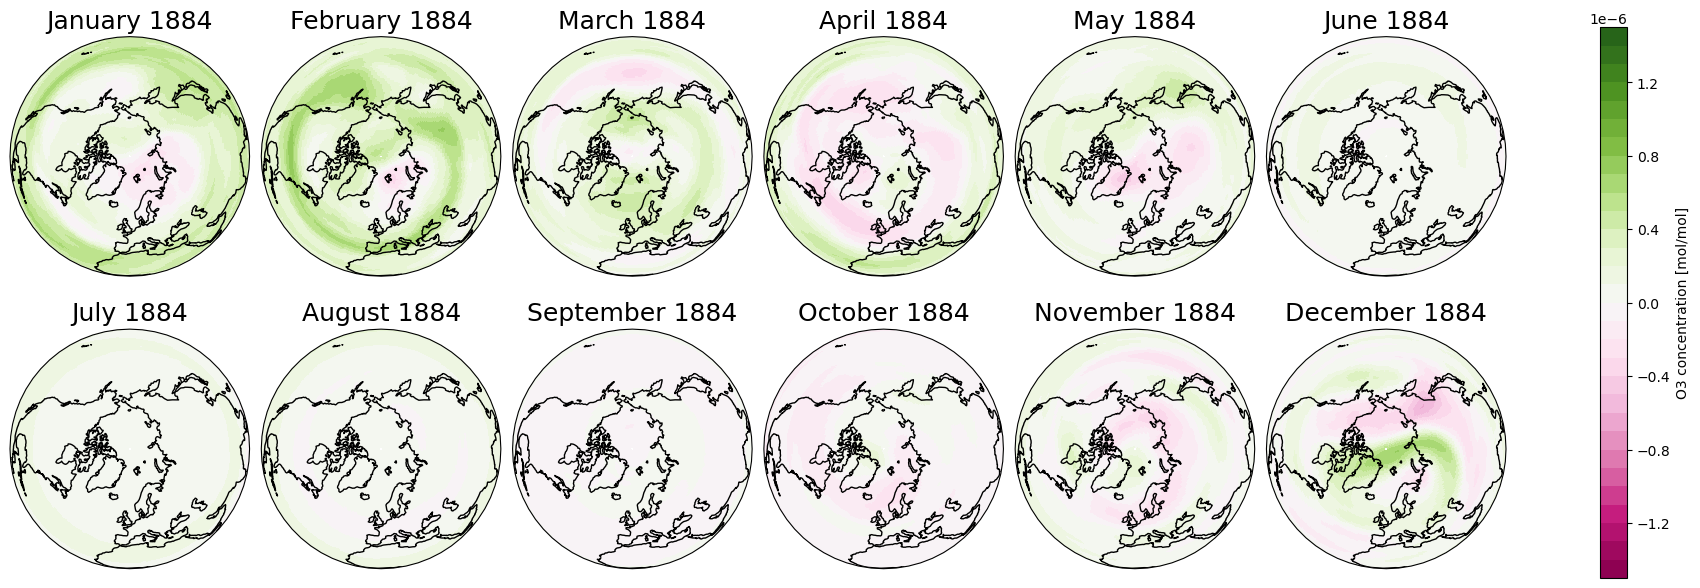

In [14]:
#Plotting ozone anomaly over northern hemisphere
#dso3_lev_16=dso3.sel(lev=51, method='nearest').drop('lev')
#dso3_lev_14=ds_o3.sel(lev=51, method='nearest').drop('lev')
dso3_his2=dso3_lhis.sel(lev=3.6, method='nearest').drop('lev')

start = cftime.DatetimeNoLeap(1877,1,15)
end_prior_eruption = cftime.DatetimeNoLeap(1882,1,15)
end = cftime.DatetimeNoLeap(1996,1,15)

#dso3_lev_16.sel(time=slice(start,end_prior_eruption))
#dso3_lev_14.sel(time=slice(start,end_prior_eruption))
dso3_his2.sel(time=slice(start, end_prior_eruption))


#climatology = dso3_lev.sel(time=slice(start, end_prior_eruption)).groupby('time.year').mean('time',keep_attrs=True).mean('year',keep_attrs=True)
#annual_mean = dso3_lev.groupby('time.year').mean('time')
#anom=dso3_lev-climatology

#anom14=calc_monthly_anomaly(dso3_lev_14,1990)

#anom16=calc_monthly_anomaly(dso3_lev_16,1990)

anomhis=calc_monthly_anomaly(dso3_his2,1882)

#anom=anom14-anom16

north_multi_plot(anomhis,1884,'PiYG')

In [ ]:
dso4= xr.open_dataset(s3.open(so4_14))
dso4.time.values;
ds_so4=dso4['mmr_SULFATE']

In [ ]:
ds_so4


In [ ]:
dso4_lev=ds_so4.sel(lev=51, method='nearest').drop('lev')

In [ ]:
#plotting SO4 

#climatology = dso4_lev.sel(time=slice(start, end_prior_eruption)).groupby('time.year').mean('time',keep_attrs=True).mean('year')
#annual_mean = dso3_lev.groupby('time.year').mean('time')
#anom=dso4_lev-climatology

north_multi_plot(dso4_lev,1992, 'hot_r')



In [ ]:
multi_plot(dso4_lev,(1991,1992),'hot_r')

In [ ]:
start = cftime.DatetimeNoLeap(1990,1,15)
end_prior_eruption = cftime.DatetimeNoLeap(1991,1,15)
end = cftime.DatetimeNoLeap(1996,1,15)

In [ ]:
#ds2_so4=ds_so4.mean('lon')
north_avrg = computeWeightedMean(ds_so4.where(ds_so4['lat']>60.)).compute()
dso4_s = north_avrg.sel(time=slice(start,end))

In [ ]:
annual_mean = dso4_s.groupby('time.year').mean('time')

annual_means= annual_mean.isel(lev=slice(0,-20))
annual_means;

In [ ]:
#Plotting to find the layer where the SO4 aerosol has its max, and when
fig, (axs1) = plt.subplots(1, 1, constrained_layout=True, figsize=(20,10))

annual_means.plot(label="NorESM 14", ax=axs1,x='year')

fig.suptitle('SO4 consentration\n', fontsize=20)

axs1.set_xlabel('Year',fontsize=20)

axs1.grid()

axs1.set_xlabel('Year', fontsize=20)
axs1.set_ylabel('Pressure level', fontsize=20)
axs1.tick_params(labelsize=15)

plt.gca().invert_yaxis()

axs1.set_title(" Northern Hemisphere yearly mean \n" , fontsize=15)



In [ ]:
ds_o32=ds_o3.mean('lon')
north_avrg = computeWeightedMean(ds_o3.where(ds_o3['lat']>60.)).compute()
ds_o33 = north_avrg.sel(time=slice(start,end))

In [ ]:
annual_mean = ds_o33.groupby('time.year').mean('time')

annual_means= annual_mean.isel(lev=slice(0,-20))
annual_means;

In [ ]:
#Plotting to find the layer where the SO2 aerosol has its max, and when
fig, (axs1) = plt.subplots(1, 1, constrained_layout=True, figsize=(20,10))

annual_means.plot(label="NorESM 14", ax=axs1,x='year')

fig.suptitle('Ozone\n', fontsize=20)

axs1.set_xlabel('Year',fontsize=20)

axs1.grid()

plt.gca().invert_yaxis()

axs1.set_title(" Northern Hemisphere \n" , fontsize=15)


In [ ]:
dso2= xr.open_dataset(s3.open(so2_14))
dso2.time.values;
dso2_=dso2['SO2']

In [ ]:
north_avrg = computeWeightedMean(dso2_.where(dso2_['lat']>60.)).compute()
dso2_s = north_avrg.sel(time=slice(start,end))

In [ ]:
dso2_

In [ ]:
annual_mean = dso2_s.groupby('time.year').mean('time')

annual_means= annual_mean.isel(lev=slice(0,-20))
annual_means;

In [ ]:
#Plotting to find the layer where the SO4 aerosol has its max, and when
fig, (axs1) = plt.subplots(1, 1, constrained_layout=True, figsize=(20,10))

annual_means.plot(label="NorESM 14", ax=axs1,x='year')

fig.suptitle('SO2\n', fontsize=20)

axs1.set_xlabel('Year',fontsize=20)

axs1.grid()

plt.gca().invert_yaxis()

axs1.set_title(" Northern Hemisphere \n" , fontsize=15)